In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from scipy.stats import pearsonr

import copy

In [2]:
df= pd.read_table('./Pre_processed_data/merged_dataframe_shopping.csv', delimiter= ',', encoding='euc-kr')

In [3]:
df.head(10)

,Unnamed: 0,ID,RCT_NO,BIZ_UNIT,PD_S_C,BR_C,BUY_AM,BUY_CT,AGE_PRD,HOM_PST_NO,...,PD_M_NM,PD_H_NM,IS_MALE,IS_FEMALE,YEAR,MONTH,DAY,HOUR,PRVIN,DESTRICT
0,0,4008,2108,A01,215,2,59600,2,50,056,...,캐주얼,여성의류,0,1,2015,2,16,13,서울특별시,송파구
1,1,6379,2109,A01,75,29,35000,1,40,480,...,건강식품,식품,1,0,2015,2,13,11,부산광역시,해운대구
2,2,6379,2109,A01,149,4,85000,1,40,480,...,화장품,잡화,1,0,2015,1,15,10,부산광역시,해운대구
3,3,8002,2110,A01,138,10,25000,1,30,300,...,섬유잡화,잡화,0,1,2015,12,20,10,세종특별자치시,NaN
4,4,8002,2110,A01,138,10,21000,1,30,300,...,섬유잡화,잡화,0,1,2015,12,20,10,세종특별자치시,NaN
5,5,8002,2110,A01,558,4,79200,1,30,300,...,구두,잡화,0,1,2015,8,15,10,세종특별자치시,NaN
6,6,7252,2111,A01,13,29,5400,1,30,490,...,가공식품,식품,0,1,2015,7,16,10,부산광역시,영도구
7,7,5072,2112,A01,223,2,158000,1,40,055,...,트래디셔널,여성의류,0,1,2015,6,26,12,서울특별시,송파구
8,8,5072,2112,A01,216,2,39000,1,40,055,...,캐주얼,여성의류,0,1,2015,2,4,12,서울특별시,송파구
9,9,5072,2112,A01,121,2,3000,1,40,055,...,가공식품,식품,0,1,2015,9,11,11,서울특별시,송파구


In [4]:
df['BIZ_n_PD']= df['BIZ_UNIT']+ df['PD_S_C'].apply(lambda x: '_'+str(x))

In [5]:
df.drop('Unnamed: 0', axis= 1, inplace= True)

In [6]:
df.drop(['YEAR', 'MONTH', 'DAY', 'HOUR'], axis= 1, inplace= True)

### pandas의 groupby, unstack 함수를 통해 ID, 소비 소품목 별로 정리된 DataFrame을 만들었음.

In [7]:
df_restructured= df.groupby(['ID', 'BIZ_n_PD']).agg({'BUY_CT': 'count'})

In [8]:
df_restructured.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1472566 entries, (1, A01_1) to (20000, A01_189)
Data columns (total 1 columns):
BUY_CT    1472566 non-null int64
dtypes: int64(1)
memory usage: 17.0+ MB


In [9]:
df_restructured= df_restructured.unstack('BIZ_n_PD')

In [10]:
df_restructured.columns= df_restructured.columns.droplevel()

In [11]:
df_restructured.columns.name= None

In [14]:
df_restructured.head()

,A01_1,A01_10,A01_100,A01_101,A01_102,A01_103,A01_104,A01_105,A01_106,A01_107,...,A05_90,A05_91,A05_92,A05_93,A05_94,A05_95,A05_96,A05_97,A05_98,A05_99
ID,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
df_restructured.fillna(0, inplace= True)

### Feature Selecting을 진행하였음.
이 때 Selecting의 기준은 표준편차 0.05 이상, 다른 Feature와의 Correlation이 0.2 이상을 넘지 않는 Feature로 설정하였음. 두 Feature의 Correlation이 0.2가 넘는 경우는 분석 시 정보량이 많을 것으로 추정되는 표준편차가 높은 Feature를 선택하였음.

In [15]:
dict_std= df_restructured.std(axis= 0).to_dict()

In [16]:
dict_std

{'A01_1': 2.976580039955692,
 'A01_10': 0.27120818267262387,
 'A01_100': 0.16913423949459439,
 'A01_101': 0.3606672623883805,
 'A01_102': 0.20724052466678403,
 'A01_103': 0.43618442379550254,
 'A01_104': 0.34808536664580253,
 'A01_105': 0.210229565181821,
 'A01_106': 1.4435126800446128,
 'A01_107': 2.801773455704306,
 'A01_108': 0.3759880635720822,
 'A01_109': 0.2654216798285304,
 'A01_11': 0.0232165457162924,
 'A01_110': 0.7501148432661009,
 'A01_111': 0.5206939139469262,
 'A01_112': 0.4746783164945243,
 'A01_113': 0.7817139787020678,
 'A01_114': 0.5719703291433863,
 'A01_115': 0.09129757848401501,
 'A01_116': 0.14957520089281373,
 'A01_117': 0.2145963149756868,
 'A01_118': 0.0207650059203332,
 'A01_119': 0.05685693525798378,
 'A01_12': 2.0367350012719605,
 'A01_120': 0.031148301976325923,
 'A01_121': 3.6689404400260712,
 'A01_122': 1.5450668241322996,
 'A01_123': 1.8825803366784082,
 'A01_124': 1.4341531382512978,
 'A01_125': 0.794241971936445,
 'A01_126': 0.12826258397583232,
 'A01_

In [17]:
df_restructured.std(axis= 0).sort_values(ascending= False)

A01_19      8.195334
A01_210     7.408167
A01_9       6.346109
A02_679     6.093122
A01_18      6.068774
A02_1620    5.968394
A03_895     5.657971
A03_776     5.628104
A01_60      5.552897
A01_20      5.501051
A01_21      5.487571
A01_82      5.290093
A03_505     5.250936
A03_486     5.077494
A01_145     5.075850
A03_469     4.884481
A02_1442    4.750082
A03_407     4.737394
A02_1433    4.661639
A02_1232    4.489105
A03_68      4.264787
A01_55      4.256383
A03_487     3.911116
A03_493     3.908495
A02_528     3.906508
A02_63      3.843815
A02_1444    3.676037
A01_121     3.668940
A04_56      3.644890
A03_894     3.490281
              ...   
A03_728     0.007342
A02_347     0.007342
A02_1303    0.007342
A02_341     0.007342
A02_714     0.007342
A03_117     0.007342
A02_485     0.007342
A03_764     0.007342
A03_855     0.007342
A03_702     0.007342
A01_362     0.007342
A02_1093    0.007342
A02_1564    0.007342
A01_43      0.007342
A01_538     0.007342
A02_474     0.007342
A03_692     0

In [18]:
ftlist=df_restructured.loc[:, df_restructured.std(axis= 0) > 0.1].columns.tolist()

In [19]:
df[df['BIZ_n_PD'].isin(ftlist)][['BIZ_n_PD', 'PD_H_NM', 'PD_M_NM', 'PD_S_NM']].drop_duplicates()

# 표준편차 0.1 이상으로 나타나는 Feature들이며, 그 개수는 2352개임

,BIZ_n_PD,PD_H_NM,PD_M_NM,PD_S_NM
0,A01_215,여성의류,캐주얼,이지캐주얼
1,A01_75,식품,건강식품,건강식품
2,A01_149,잡화,화장품,기초A
3,A01_138,잡화,섬유잡화,기타
5,A01_558,잡화,구두,캐주얼화
6,A01_13,식품,가공식품,일식델리
7,A01_223,여성의류,트래디셔널,트래디셔널
8,A01_216,여성의류,캐주얼,쿨캐주얼
9,A01_121,식품,가공식품,식당가 한식
11,A01_421,스포츠,스포츠,스포츠화


In [20]:
print(len(ftlist))

2352


In [21]:
not_ftlist=df_restructured.loc[:, df_restructured.std(axis= 0) < 0.1].columns.tolist()

In [22]:
print(len(not_ftlist))

1436


In [23]:
df[df['BIZ_n_PD'].isin(not_ftlist)][['BIZ_n_PD', 'PD_H_NM', 'PD_M_NM', 'PD_S_NM']].drop_duplicates()

# 표준편차 0.1 미만으로 나타나는 Feature들이며, 그 개수는 1436개임. 해당 Feature는 제외하였음.

,BIZ_n_PD,PD_H_NM,PD_M_NM,PD_S_NM
129,A01_564,명품,명품,갤러리
204,A01_275,남성의류,남성 트랜디,시리즈
483,A01_344,스포츠,스포츠,트렉스타(신)
556,A01_150,잡화,화장품,화장품
776,A03_619,일상용품,위생용품,핸드로션/크림
851,A03_315,일반식품,즉석식품,즉석스프
856,A03_652,일상용품,화장품,면봉/화장솜
863,A03_177,수산,선어류,전어
912,A03_635,일상용품,생리용품,성인용일회용팬티
1148,A01_606,잡화,구두,파크랜드


In [24]:
df[df['BIZ_n_PD']=='A01_19'].head()

,ID,RCT_NO,BIZ_UNIT,PD_S_C,BR_C,BUY_AM,BUY_CT,AGE_PRD,HOM_PST_NO,PD_S_NM,PD_M_NM,PD_H_NM,IS_MALE,IS_FEMALE,PRVIN,DESTRICT,BIZ_n_PD
2232,4380,251227,A01,19,2,10000,1,40,056,채소,농산물,식품,1,0,서울특별시,송파구,A01_19
2265,9448,251239,A01,19,17,3800,1,40,130,채소,농산물,식품,0,1,경기도,하남시,A01_19
2785,9530,251321,A01,19,17,3600,2,50,130,채소,농산물,식품,0,1,경기도,하남시,A01_19
2855,8570,251365,A01,19,12,1000,1,30,062,채소,농산물,식품,0,1,서울특별시,강남구,A01_19
2857,8570,251365,A01,19,12,1580,1,30,062,채소,농산물,식품,0,1,서울특별시,강남구,A01_19


In [25]:
sns.set()

In [26]:
grp= sns.distplot(df_restructured['A01_19'], kde= False)

In [27]:
grp.set_xscale('log')

In [28]:
grp.set_yscale('log')

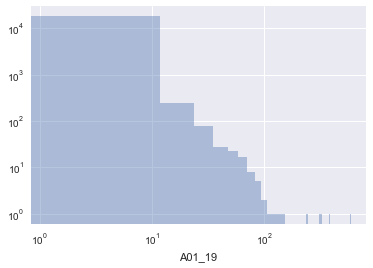

In [29]:
plt.show()

# 가장 표준편차가 높게 나타난 A01_19(채소 소품목)에 대해 시각화해 보았음.

In [30]:
grp= sns.distplot(df_restructured.loc[:, df_restructured.std(axis= 0) < 0.1].mean(axis= 0), kde= False)

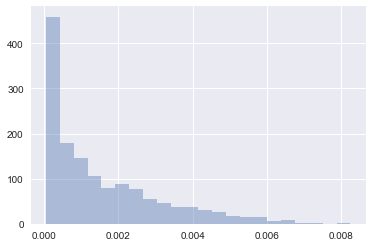

In [31]:
plt.show()

# 해당 코드에서 표준편차가 작게 나타난 소품목들에 대해서도 확인해 보았음.
# 분산이 작게 나타난 품목의 경우 품목의 평균이 0~0.008 수준으로 나타났음.
# 이러한 소품목의 경우 정보를 거의 가지고 있지 않은 것으로 판단하였음.

In [32]:
grp= sns.distplot(df_restructured['A02_728'], color= 'green', kde= False)

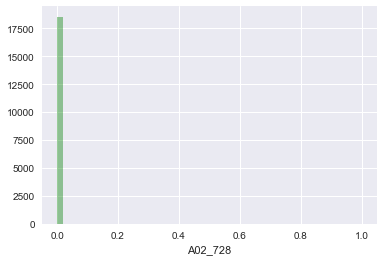

In [33]:
plt.show()

In [34]:
df_ft_select= df_restructured[ftlist]

In [35]:
df_ft_select.head()

,A01_1,A01_10,A01_100,A01_101,A01_102,A01_103,A01_104,A01_105,A01_106,A01_107,...,A05_89,A05_9,A05_90,A05_91,A05_92,A05_93,A05_95,A05_97,A05_98,A05_99
ID,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
loop_list= copy.deepcopy(ftlist)
remove_list= []
remain_list= []
while loop_list:
    ft= loop_list.pop(0)
    remain_list.append(ft)
    print(ft)
    for ft2 in loop_list:
        (coef_, p_val)= pearsonr(df_restructured[ft], df_restructured[ft2])
        if p_val<=0.05 and abs(coef_)>0.2:
            if dict_std[ft]>dict_std[ft2]:
                print('{} is deleted- remain: {}, coef_: {:4f}, p_val: {:4f}, dict_std: {:4f}, {:4f}'.format(ft2, ft, coef_, p_val, dict_std[ft], dict_std[ft2]))
                remove_list.append(ft2)
            else:
                print('{} is deleted- remain: {}, coef_: {:4f}, p_val: {:4f}, dict_std: {:4f}, {:4f}'.format(ft, ft2, coef_, p_val, dict_std[ft], dict_std[ft2]))
                remain_list.remove(ft)
                break
    if remove_list:
        for elmt in remove_list:
            loop_list.remove(elmt)
        remove_list= []


A01_1
A01_12 is deleted- remain: A01_1, coef_: 0.394778, p_val: 0.000000, dict_std: 2.976580, 2.036735
A01_1 is deleted- remain: A01_121, coef_: 0.210990, p_val: 0.000000, dict_std: 2.976580, 3.668940
A01_10
A01_64 is deleted- remain: A01_10, coef_: 0.201467, p_val: 0.000000, dict_std: 0.271208, 0.152047
A01_100
A01_100 is deleted- remain: A01_107, coef_: 0.225395, p_val: 0.000000, dict_std: 0.169134, 2.801773
A01_101
A01_102
A01_102 is deleted- remain: A01_105, coef_: 0.242877, p_val: 0.000000, dict_std: 0.207241, 0.210230
A01_103
A01_104
A01_105 is deleted- remain: A01_104, coef_: 0.403101, p_val: 0.000000, dict_std: 0.348085, 0.210230
A01_106
A01_106 is deleted- remain: A01_14, coef_: 0.214142, p_val: 0.000000, dict_std: 1.443513, 1.800212
A01_107
A01_109 is deleted- remain: A01_107, coef_: 0.241138, p_val: 0.000000, dict_std: 2.801773, 0.265422
A01_13 is deleted- remain: A01_107, coef_: 0.215143, p_val: 0.000000, dict_std: 2.801773, 2.537684
A01_156 is deleted- remain: A01_107, coe

A01_85 is deleted- remain: A01_19, coef_: 0.329503, p_val: 0.000000, dict_std: 8.195334, 1.884367
A01_86 is deleted- remain: A01_19, coef_: 0.498583, p_val: 0.000000, dict_std: 8.195334, 3.240264
A01_88 is deleted- remain: A01_19, coef_: 0.210144, p_val: 0.000000, dict_std: 8.195334, 1.250665
A01_89 is deleted- remain: A01_19, coef_: 0.539195, p_val: 0.000000, dict_std: 8.195334, 0.916453
A01_9 is deleted- remain: A01_19, coef_: 0.632699, p_val: 0.000000, dict_std: 8.195334, 6.346109
A01_190
A01_191
A01_192
A01_192 is deleted- remain: A01_262, coef_: 0.277874, p_val: 0.000000, dict_std: 0.195245, 0.379687
A01_193
A01_386 is deleted- remain: A01_193, coef_: 0.215302, p_val: 0.000000, dict_std: 0.174859, 0.149870
A01_194
A01_195
A01_196
A01_197
A01_198
A01_198 is deleted- remain: A01_199, coef_: 0.209942, p_val: 0.000000, dict_std: 0.330538, 0.345398
A01_199
A01_199 is deleted- remain: A01_223, coef_: 0.221219, p_val: 0.000000, dict_std: 0.345398, 1.561835
A01_200
A01_200 is deleted- rem

A01_48 is deleted- remain: A01_529, coef_: 0.207364, p_val: 0.000000, dict_std: 0.165964, 0.439166
A01_484
A01_485
A01_485 is deleted- remain: A01_488, coef_: 0.364726, p_val: 0.000000, dict_std: 0.382937, 0.738624
A01_486
A01_488
A01_491
A01_492
A01_493
A01_493 is deleted- remain: A01_513, coef_: 0.231854, p_val: 0.000000, dict_std: 0.240145, 0.648742
A01_494
A01_494 is deleted- remain: A03_533, coef_: 0.216556, p_val: 0.000000, dict_std: 0.221176, 0.224548
A01_496
A01_497
A01_497 is deleted- remain: A01_513, coef_: 0.267826, p_val: 0.000000, dict_std: 0.298374, 0.648742
A01_499
A01_501 is deleted- remain: A01_499, coef_: 0.223570, p_val: 0.000000, dict_std: 1.006386, 0.297606
A01_513 is deleted- remain: A01_499, coef_: 0.220039, p_val: 0.000000, dict_std: 1.006386, 0.648742
A01_5
A01_500
A01_503
A01_506
A01_509
A01_510
A02_1551 is deleted- remain: A01_510, coef_: 0.206293, p_val: 0.000000, dict_std: 0.272642, 0.268225
A02_734 is deleted- remain: A01_510, coef_: 0.203589, p_val: 0.000

A02_1050
A02_1184 is deleted- remain: A02_1050, coef_: 0.371689, p_val: 0.000000, dict_std: 0.395407, 0.361602
A02_209 is deleted- remain: A02_1050, coef_: 0.228173, p_val: 0.000000, dict_std: 0.395407, 0.336723
A02_904 is deleted- remain: A02_1050, coef_: 0.327148, p_val: 0.000000, dict_std: 0.395407, 0.265202
A02_1050 is deleted- remain: A04_35, coef_: 0.207577, p_val: 0.000000, dict_std: 0.395407, 1.056045
A02_1052
A02_1052 is deleted- remain: A02_1064, coef_: 0.277617, p_val: 0.000000, dict_std: 0.569824, 2.060610
A02_1053
A02_1053 is deleted- remain: A02_1064, coef_: 0.272447, p_val: 0.000000, dict_std: 0.518454, 2.060610
A02_1054
A02_1058
A02_1058 is deleted- remain: A02_1059, coef_: 0.201171, p_val: 0.000000, dict_std: 0.261571, 0.369867
A02_1059
A02_1059 is deleted- remain: A02_1064, coef_: 0.311272, p_val: 0.000000, dict_std: 0.369867, 2.060610
A02_1062
A02_1062 is deleted- remain: A02_1064, coef_: 0.225149, p_val: 0.000000, dict_std: 0.288566, 2.060610
A02_1064
A02_1065 is de

A02_1179 is deleted- remain: A02_1163, coef_: 0.210761, p_val: 0.000000, dict_std: 2.363663, 0.444860
A02_1163 is deleted- remain: A02_1183, coef_: 0.269855, p_val: 0.000000, dict_std: 2.363663, 3.426242
A02_1165
A02_1165 is deleted- remain: A02_538, coef_: 0.203131, p_val: 0.000000, dict_std: 0.390338, 1.209029
A02_1167
A02_1168
A02_1168 is deleted- remain: A02_1445, coef_: 0.216031, p_val: 0.000000, dict_std: 0.150054, 2.363794
A02_1169
A02_1169 is deleted- remain: A02_1217, coef_: 0.234645, p_val: 0.000000, dict_std: 0.282997, 0.768556
A02_1170
A02_1170 is deleted- remain: A02_1195, coef_: 0.234462, p_val: 0.000000, dict_std: 0.384797, 0.792978
A02_1171
A02_1171 is deleted- remain: A02_1215, coef_: 0.256781, p_val: 0.000000, dict_std: 0.328274, 0.618197
A02_1172
A02_1172 is deleted- remain: A02_1217, coef_: 0.224154, p_val: 0.000000, dict_std: 0.294227, 0.768556
A02_1174
A02_1174 is deleted- remain: A02_2, coef_: 0.202724, p_val: 0.000000, dict_std: 0.278865, 0.589628
A02_1175
A02_1

A02_1314 is deleted- remain: A02_1232, coef_: 0.265475, p_val: 0.000000, dict_std: 4.489105, 2.296017
A02_1315 is deleted- remain: A02_1232, coef_: 0.230628, p_val: 0.000000, dict_std: 4.489105, 0.339390
A02_133 is deleted- remain: A02_1232, coef_: 0.223271, p_val: 0.000000, dict_std: 4.489105, 0.459090
A02_1352 is deleted- remain: A02_1232, coef_: 0.238699, p_val: 0.000000, dict_std: 4.489105, 0.531754
A02_1365 is deleted- remain: A02_1232, coef_: 0.375595, p_val: 0.000000, dict_std: 4.489105, 1.060088
A02_1373 is deleted- remain: A02_1232, coef_: 0.225006, p_val: 0.000000, dict_std: 4.489105, 0.377693
A02_1376 is deleted- remain: A02_1232, coef_: 0.219243, p_val: 0.000000, dict_std: 4.489105, 0.631591
A02_1415 is deleted- remain: A02_1232, coef_: 0.223595, p_val: 0.000000, dict_std: 4.489105, 0.464483
A02_1431 is deleted- remain: A02_1232, coef_: 0.497914, p_val: 0.000000, dict_std: 4.489105, 2.936177
A02_1432 is deleted- remain: A02_1232, coef_: 0.463710, p_val: 0.000000, dict_std: 

A02_1388 is deleted- remain: A02_1591, coef_: 0.214921, p_val: 0.000000, dict_std: 0.167065, 1.110296
A02_139
A02_1390
A02_1390 is deleted- remain: A02_1457, coef_: 0.216303, p_val: 0.000000, dict_std: 0.191257, 0.304328
A02_1391
A02_1580 is deleted- remain: A02_1391, coef_: 0.221635, p_val: 0.000000, dict_std: 0.350560, 0.226867
A02_1392
A02_1394 is deleted- remain: A02_1392, coef_: 0.257277, p_val: 0.000000, dict_std: 0.230180, 0.109675
A02_1395
A02_1395 is deleted- remain: A02_1445, coef_: 0.200307, p_val: 0.000000, dict_std: 0.337442, 2.363794
A02_1396
A02_1399
A02_1399 is deleted- remain: A02_1460, coef_: 0.225308, p_val: 0.000000, dict_std: 0.428684, 1.353249
A02_14
A02_14 is deleted- remain: A02_15, coef_: 0.260314, p_val: 0.000000, dict_std: 0.231982, 0.831422
A02_1400
A02_1402
A02_782 is deleted- remain: A02_1402, coef_: 0.216338, p_val: 0.000000, dict_std: 0.215756, 0.110808
A02_1404
A02_1406
A02_1406 is deleted- remain: A02_934, coef_: 0.201562, p_val: 0.000000, dict_std: 0.

A02_1490
A02_1491
A02_1491 is deleted- remain: A02_552, coef_: 0.317009, p_val: 0.000000, dict_std: 0.141578, 0.192306
A02_1498
A02_1498 is deleted- remain: A02_17, coef_: 0.200210, p_val: 0.000000, dict_std: 0.277697, 1.523071
A02_150
A02_1501
A02_1502
A02_1504 is deleted- remain: A02_1502, coef_: 0.233001, p_val: 0.000000, dict_std: 0.355023, 0.274423
A02_1503
A02_219 is deleted- remain: A02_1503, coef_: 0.200930, p_val: 0.000000, dict_std: 0.352912, 0.246096
A02_1505
A02_1505 is deleted- remain: A04_48, coef_: 0.210028, p_val: 0.000000, dict_std: 0.131291, 0.149598
A02_1506
A02_1507
A02_1508
A03_293 is deleted- remain: A02_1508, coef_: 0.269011, p_val: 0.000000, dict_std: 0.501049, 0.164863
A02_151
A02_1511
A02_1514
A02_1515
A02_1516
A02_1516 is deleted- remain: A02_1518, coef_: 0.249421, p_val: 0.000000, dict_std: 0.246024, 0.271908
A02_1518
A02_1522
A02_1523
A02_1523 is deleted- remain: A02_1526, coef_: 0.230520, p_val: 0.000000, dict_std: 0.195145, 0.284085
A02_1524
A02_1525
A04_

A02_517 is deleted- remain: A02_1620, coef_: 0.282600, p_val: 0.000000, dict_std: 5.968394, 0.613714
A02_52 is deleted- remain: A02_1620, coef_: 0.245219, p_val: 0.000000, dict_std: 5.968394, 0.913607
A02_528 is deleted- remain: A02_1620, coef_: 0.287703, p_val: 0.000000, dict_std: 5.968394, 3.906508
A02_532 is deleted- remain: A02_1620, coef_: 0.230443, p_val: 0.000000, dict_std: 5.968394, 0.698082
A02_533 is deleted- remain: A02_1620, coef_: 0.235141, p_val: 0.000000, dict_std: 5.968394, 0.451817
A02_538 is deleted- remain: A02_1620, coef_: 0.240462, p_val: 0.000000, dict_std: 5.968394, 1.209029
A02_54 is deleted- remain: A02_1620, coef_: 0.277105, p_val: 0.000000, dict_std: 5.968394, 1.113509
A02_55 is deleted- remain: A02_1620, coef_: 0.231668, p_val: 0.000000, dict_std: 5.968394, 1.375542
A02_566 is deleted- remain: A02_1620, coef_: 0.207546, p_val: 0.000000, dict_std: 5.968394, 0.277233
A02_569 is deleted- remain: A02_1620, coef_: 0.215996, p_val: 0.000000, dict_std: 5.968394, 0.

A02_306
A02_307
A02_307 is deleted- remain: A04_130, coef_: 0.241349, p_val: 0.000000, dict_std: 0.119867, 0.905412
A02_31
A02_31 is deleted- remain: A02_328, coef_: 0.224962, p_val: 0.000000, dict_std: 0.286099, 0.992589
A02_314
A02_318
A02_319
A02_32
A02_321
A02_325
A02_326
A02_328
A02_33
A02_509 is deleted- remain: A02_33, coef_: 0.213278, p_val: 0.000000, dict_std: 0.316084, 0.151475
A02_33 is deleted- remain: A02_86, coef_: 0.291242, p_val: 0.000000, dict_std: 0.316084, 0.781264
A02_330
A02_335
A02_335 is deleted- remain: A02_381, coef_: 0.206836, p_val: 0.000000, dict_std: 0.188164, 0.364543
A02_336
A02_337
A02_34
A02_559 is deleted- remain: A02_34, coef_: 0.266011, p_val: 0.000000, dict_std: 1.217278, 0.128334
A02_34 is deleted- remain: A02_610, coef_: 0.306218, p_val: 0.000000, dict_std: 1.217278, 2.135541
A02_345
A02_345 is deleted- remain: A02_495, coef_: 0.320932, p_val: 0.000000, dict_std: 0.133647, 1.896808
A02_349
A02_349 is deleted- remain: A02_495, coef_: 0.224076, p_va

A02_646
A02_647 is deleted- remain: A02_646, coef_: 0.225203, p_val: 0.000000, dict_std: 0.355705, 0.281418
A02_650
A02_652
A02_652 is deleted- remain: A02_653, coef_: 0.554216, p_val: 0.000000, dict_std: 0.329067, 0.394225
A02_653
A02_654 is deleted- remain: A02_653, coef_: 0.210052, p_val: 0.000000, dict_std: 0.394225, 0.368793
A02_658 is deleted- remain: A02_653, coef_: 0.268224, p_val: 0.000000, dict_std: 0.394225, 0.164677
A02_9 is deleted- remain: A02_653, coef_: 0.200904, p_val: 0.000000, dict_std: 0.394225, 0.200302
A02_655
A02_66
A02_664
A02_664 is deleted- remain: A02_666, coef_: 0.224671, p_val: 0.000000, dict_std: 0.119072, 0.146088
A02_666
A02_670
A02_672
A02_672 is deleted- remain: A02_675, coef_: 0.203648, p_val: 0.000000, dict_std: 0.182107, 0.260852
A02_673
A02_674
A02_675
A02_675 is deleted- remain: A02_73, coef_: 0.251157, p_val: 0.000000, dict_std: 0.260852, 1.039990
A02_676
A02_677
A02_678
A02_678 is deleted- remain: A02_74, coef_: 0.222158, p_val: 0.000000, dict_s

A02_742
A02_743
A02_745
A05_128 is deleted- remain: A02_745, coef_: 0.234755, p_val: 0.000000, dict_std: 0.186725, 0.123239
A02_746
A02_747
A02_748
A02_750
A02_752
A02_753
A02_755
A02_755 is deleted- remain: A02_823, coef_: 0.295227, p_val: 0.000000, dict_std: 0.212180, 0.275206
A02_756
A02_759
A02_760
A02_761
A02_761 is deleted- remain: A02_979, coef_: 0.240744, p_val: 0.000000, dict_std: 0.212789, 0.284353
A02_764
A02_768
A02_769
A02_769 is deleted- remain: A02_771, coef_: 0.249662, p_val: 0.000000, dict_std: 0.110557, 0.138083
A02_77
A02_770
A02_771
A02_776
A02_778
A02_779
A02_783 is deleted- remain: A02_779, coef_: 0.312902, p_val: 0.000000, dict_std: 0.148748, 0.142494
A02_78
A02_780
A02_781
A02_785
A02_789
A02_79
A02_792
A02_792 is deleted- remain: A02_888, coef_: 0.241381, p_val: 0.000000, dict_std: 0.383223, 0.410230
A02_793
A02_796
A02_797
A02_959 is deleted- remain: A02_797, coef_: 0.244206, p_val: 0.000000, dict_std: 0.258328, 0.236055
A02_801
A02_802
A02_802 is deleted- rem

A03_188 is deleted- remain: A03_104, coef_: 0.207903, p_val: 0.000000, dict_std: 2.765880, 0.369636
A03_19 is deleted- remain: A03_104, coef_: 0.523604, p_val: 0.000000, dict_std: 2.765880, 1.119468
A03_191 is deleted- remain: A03_104, coef_: 0.270636, p_val: 0.000000, dict_std: 2.765880, 0.659001
A03_20 is deleted- remain: A03_104, coef_: 0.384370, p_val: 0.000000, dict_std: 2.765880, 0.434310
A03_209 is deleted- remain: A03_104, coef_: 0.278789, p_val: 0.000000, dict_std: 2.765880, 0.485542
A03_21 is deleted- remain: A03_104, coef_: 0.510549, p_val: 0.000000, dict_std: 2.765880, 1.339116
A03_213 is deleted- remain: A03_104, coef_: 0.252137, p_val: 0.000000, dict_std: 2.765880, 0.338268
A03_222 is deleted- remain: A03_104, coef_: 0.255291, p_val: 0.000000, dict_std: 2.765880, 0.300562
A03_225 is deleted- remain: A03_104, coef_: 0.220724, p_val: 0.000000, dict_std: 2.765880, 0.291745
A03_228 is deleted- remain: A03_104, coef_: 0.295507, p_val: 0.000000, dict_std: 2.765880, 0.595671
A03

A03_246 is deleted- remain: A03_35, coef_: 0.209198, p_val: 0.000000, dict_std: 0.384276, 0.822802
A03_247
A03_249 is deleted- remain: A03_247, coef_: 0.262297, p_val: 0.000000, dict_std: 0.199936, 0.104030
A03_253
A03_253 is deleted- remain: A03_36, coef_: 0.268969, p_val: 0.000000, dict_std: 0.126601, 0.346483
A03_269
A03_269 is deleted- remain: A03_270, coef_: 0.309093, p_val: 0.000000, dict_std: 0.190333, 0.266118
A03_270
A03_270 is deleted- remain: A03_285, coef_: 0.203913, p_val: 0.000000, dict_std: 0.266118, 3.370598
A03_271
A03_271 is deleted- remain: A03_290, coef_: 0.211630, p_val: 0.000000, dict_std: 0.103765, 0.655718
A03_272
A03_758 is deleted- remain: A03_272, coef_: 0.281653, p_val: 0.000000, dict_std: 0.269949, 0.122512
A03_272 is deleted- remain: A03_814, coef_: 0.368373, p_val: 0.000000, dict_std: 0.269949, 1.079909
A03_277
A03_277 is deleted- remain: A03_285, coef_: 0.201999, p_val: 0.000000, dict_std: 0.141009, 3.370598
A03_278
A03_278 is deleted- remain: A03_279, c

A03_286 is deleted- remain: A03_519, coef_: 0.287666, p_val: 0.000000, dict_std: 0.274115, 1.107182
A03_299
A03_305
A03_305 is deleted- remain: A03_407, coef_: 0.269022, p_val: 0.000000, dict_std: 0.602143, 4.737394
A03_313
A03_318 is deleted- remain: A03_313, coef_: 0.337882, p_val: 0.000000, dict_std: 0.418635, 0.243253
A03_440 is deleted- remain: A03_313, coef_: 0.308837, p_val: 0.000000, dict_std: 0.418635, 0.279357
A03_313 is deleted- remain: A03_505, coef_: 0.201742, p_val: 0.000000, dict_std: 0.418635, 5.250936
A03_314
A03_314 is deleted- remain: A03_611, coef_: 0.204921, p_val: 0.000000, dict_std: 0.199558, 0.214389
A03_316
A03_317
A03_327
A03_327 is deleted- remain: A03_68, coef_: 0.201519, p_val: 0.000000, dict_std: 0.233010, 4.264787
A03_328
A03_330
A03_330 is deleted- remain: A03_69, coef_: 0.268588, p_val: 0.000000, dict_std: 0.114997, 0.442643
A03_331
A03_331 is deleted- remain: A03_407, coef_: 0.201579, p_val: 0.000000, dict_std: 0.308038, 4.737394
A03_340
A03_366
A03_36

A03_476 is deleted- remain: A03_542, coef_: 0.230217, p_val: 0.000000, dict_std: 0.153664, 0.243222
A03_479
A03_479 is deleted- remain: A03_486, coef_: 0.263278, p_val: 0.000000, dict_std: 0.552707, 5.077494
A03_483
A03_486
A03_487 is deleted- remain: A03_486, coef_: 0.268364, p_val: 0.000000, dict_std: 5.077494, 3.911116
A03_488 is deleted- remain: A03_486, coef_: 0.370417, p_val: 0.000000, dict_std: 5.077494, 3.007817
A03_49 is deleted- remain: A03_486, coef_: 0.357089, p_val: 0.000000, dict_std: 5.077494, 0.816198
A03_490 is deleted- remain: A03_486, coef_: 0.322804, p_val: 0.000000, dict_std: 5.077494, 0.263380
A03_491 is deleted- remain: A03_486, coef_: 0.436050, p_val: 0.000000, dict_std: 5.077494, 1.141933
A03_492 is deleted- remain: A03_486, coef_: 0.367894, p_val: 0.000000, dict_std: 5.077494, 2.035417
A03_493 is deleted- remain: A03_486, coef_: 0.423968, p_val: 0.000000, dict_std: 5.077494, 3.908495
A03_494 is deleted- remain: A03_486, coef_: 0.438782, p_val: 0.000000, dict_s

A03_537 is deleted- remain: A03_776, coef_: 0.240912, p_val: 0.000000, dict_std: 0.174315, 5.628104
A03_54
A03_54 is deleted- remain: A03_57, coef_: 0.264687, p_val: 0.000000, dict_std: 0.356186, 0.437496
A03_541
A03_547 is deleted- remain: A03_541, coef_: 0.249301, p_val: 0.000000, dict_std: 0.401981, 0.134066
A03_541 is deleted- remain: A03_564, coef_: 0.347344, p_val: 0.000000, dict_std: 0.401981, 0.403002
A03_542
A03_542 is deleted- remain: A03_543, coef_: 0.215964, p_val: 0.000000, dict_std: 0.243222, 0.261704
A03_543
A03_543 is deleted- remain: A03_568, coef_: 0.280778, p_val: 0.000000, dict_std: 0.261704, 1.752538
A03_546
A03_552
A03_552 is deleted- remain: A03_560, coef_: 0.316708, p_val: 0.000000, dict_std: 0.474466, 0.725215
A03_553
A03_553 is deleted- remain: A03_560, coef_: 0.215499, p_val: 0.000000, dict_std: 0.189482, 0.725215
A03_557
A03_559
A03_560
A03_564 is deleted- remain: A03_560, coef_: 0.201821, p_val: 0.000000, dict_std: 0.725215, 0.403002
A03_560 is deleted- rem

A03_99
A04_1
A04_101 is deleted- remain: A04_1, coef_: 0.356574, p_val: 0.000000, dict_std: 2.637215, 0.122433
A04_103 is deleted- remain: A04_1, coef_: 0.235475, p_val: 0.000000, dict_std: 2.637215, 0.278840
A04_11 is deleted- remain: A04_1, coef_: 0.229759, p_val: 0.000000, dict_std: 2.637215, 0.135966
A04_12 is deleted- remain: A04_1, coef_: 0.276597, p_val: 0.000000, dict_std: 2.637215, 0.153750
A04_124 is deleted- remain: A04_1, coef_: 0.297247, p_val: 0.000000, dict_std: 2.637215, 0.976651
A04_125 is deleted- remain: A04_1, coef_: 0.283507, p_val: 0.000000, dict_std: 2.637215, 1.023090
A04_126 is deleted- remain: A04_1, coef_: 0.276050, p_val: 0.000000, dict_std: 2.637215, 0.810542
A04_128 is deleted- remain: A04_1, coef_: 0.218272, p_val: 0.000000, dict_std: 2.637215, 0.364819
A04_131 is deleted- remain: A04_1, coef_: 0.381566, p_val: 0.000000, dict_std: 2.637215, 1.993534
A04_132 is deleted- remain: A04_1, coef_: 0.350100, p_val: 0.000000, dict_std: 2.637215, 1.894665
A04_133 i

A04_163 is deleted- remain: A04_35, coef_: 0.206634, p_val: 0.000000, dict_std: 0.268714, 1.056045
A04_186
A04_186 is deleted- remain: A04_6, coef_: 0.249815, p_val: 0.000000, dict_std: 0.172086, 1.376979
A04_205
A04_253 is deleted- remain: A04_205, coef_: 0.207989, p_val: 0.000000, dict_std: 0.140699, 0.102173
A04_205 is deleted- remain: A04_289, coef_: 0.209292, p_val: 0.000000, dict_std: 0.140699, 0.997673
A04_230
A04_230 is deleted- remain: A04_268, coef_: 0.288710, p_val: 0.000000, dict_std: 0.105823, 0.338465
A04_231
A05_1 is deleted- remain: A04_231, coef_: 0.372664, p_val: 0.000000, dict_std: 0.360431, 0.110824
A05_11 is deleted- remain: A04_231, coef_: 0.210854, p_val: 0.000000, dict_std: 0.360431, 0.162299
A04_233
A04_233 is deleted- remain: A04_61, coef_: 0.234800, p_val: 0.000000, dict_std: 0.119942, 0.854624
A04_239
A04_244 is deleted- remain: A04_239, coef_: 0.258475, p_val: 0.000000, dict_std: 0.138551, 0.121001
A04_239 is deleted- remain: A04_245, coef_: 0.239768, p_val

A04_373 is deleted- remain: A04_432, coef_: 0.298307, p_val: 0.000000, dict_std: 0.160979, 0.336701
A04_374
A04_375 is deleted- remain: A04_374, coef_: 0.976755, p_val: 0.000000, dict_std: 0.326119, 0.135379
A04_378 is deleted- remain: A04_374, coef_: 0.988226, p_val: 0.000000, dict_std: 0.326119, 0.207404
A04_385 is deleted- remain: A04_374, coef_: 0.985398, p_val: 0.000000, dict_std: 0.326119, 0.207664
A04_393 is deleted- remain: A04_374, coef_: 0.979548, p_val: 0.000000, dict_std: 0.326119, 0.255807
A04_399 is deleted- remain: A04_374, coef_: 0.928762, p_val: 0.000000, dict_std: 0.326119, 0.189154
A04_409 is deleted- remain: A04_374, coef_: 0.966235, p_val: 0.000000, dict_std: 0.326119, 0.210758
A04_410 is deleted- remain: A04_374, coef_: 0.300454, p_val: 0.000000, dict_std: 0.326119, 0.210121
A04_417 is deleted- remain: A04_374, coef_: 0.983618, p_val: 0.000000, dict_std: 0.326119, 0.192580
A04_374 is deleted- remain: A04_425, coef_: 0.949652, p_val: 0.000000, dict_std: 0.326119, 0

In [37]:
print(len(remain_list), remain_list)

738 ['A01_10', 'A01_101', 'A01_103', 'A01_104', 'A01_107', 'A01_110', 'A01_111', 'A01_112', 'A01_113', 'A01_117', 'A01_125', 'A01_128', 'A01_131', 'A01_133', 'A01_137', 'A01_138', 'A01_140', 'A01_141', 'A01_142', 'A01_143', 'A01_147', 'A01_148', 'A01_149', 'A01_151', 'A01_153', 'A01_157', 'A01_158', 'A01_160', 'A01_162', 'A01_163', 'A01_168', 'A01_173', 'A01_176', 'A01_179', 'A01_180', 'A01_182', 'A01_184', 'A01_187', 'A01_188', 'A01_19', 'A01_190', 'A01_191', 'A01_193', 'A01_194', 'A01_195', 'A01_196', 'A01_197', 'A01_201', 'A01_204', 'A01_207', 'A01_208', 'A01_209', 'A01_210', 'A01_217', 'A01_219', 'A01_221', 'A01_223', 'A01_228', 'A01_231', 'A01_233', 'A01_235', 'A01_236', 'A01_240', 'A01_242', 'A01_245', 'A01_259', 'A01_26', 'A01_263', 'A01_27', 'A01_291', 'A01_292', 'A01_294', 'A01_296', 'A01_297', 'A01_298', 'A01_299', 'A01_300', 'A01_301', 'A01_302', 'A01_308', 'A01_309', 'A01_313', 'A01_316', 'A01_318', 'A01_319', 'A01_320', 'A01_321', 'A01_323', 'A01_325', 'A01_327', 'A01_328'

In [38]:
df_ft_select= df_ft_select[remain_list]

In [39]:
df_ft_select.std(axis= 0)

A01_10     0.271208
A01_101    0.360667
A01_103    0.436184
A01_104    0.348085
A01_107    2.801773
A01_110    0.750115
A01_111    0.520694
A01_112    0.474678
A01_113    0.781714
A01_117    0.214596
A01_125    0.794242
A01_128    0.567174
A01_131    0.721621
A01_133    0.264931
A01_137    0.359565
A01_138    0.670558
A01_140    0.101366
A01_141    0.101236
A01_142    0.211797
A01_143    0.354984
A01_147    0.410456
A01_148    0.408230
A01_149    1.827749
A01_151    0.198030
A01_153    0.281029
A01_157    0.384354
A01_158    0.634643
A01_160    0.722966
A01_162    0.363244
A01_163    0.268820
             ...   
A04_56     3.644890
A04_64     0.407828
A04_66     0.707602
A04_67     0.143235
A04_72     0.478075
A04_77     0.901310
A04_87     0.338377
A05_109    0.122787
A05_121    0.127319
A05_130    0.117049
A05_134    0.121222
A05_36     0.201247
A05_40     0.324900
A05_45     0.196504
A05_50     0.143270
A05_51     0.110596
A05_52     0.115459
A05_60     0.142389
A05_63     0.148281


In [40]:
df_feature= df[df['BIZ_n_PD'].isin(remain_list)][['BIZ_n_PD', 'PD_H_NM', 'PD_M_NM', 'PD_S_NM']].drop_duplicates()

In [43]:
df_feature.head(30)

,BIZ_n_PD,PD_H_NM,PD_M_NM,PD_S_NM
2,A01_149,잡화,화장품,기초A
3,A01_138,잡화,섬유잡화,기타
5,A01_558,잡화,구두,캐주얼화
7,A01_223,여성의류,트래디셔널,트래디셔널
13,A01_532,명품,명품,명품남성
14,A01_113,식품,가공식품,대형테넌트
15,A01_143,잡화,액세서리,아이웨어
17,A01_531,명품,명품,컨템포러리
18,A01_208,여성의류,캐주얼,영 캐릭터
21,A01_107,식품,가공식품,브랜드샵


In [68]:
df_feature.to_pickle('features_std0.1_corr0.2.pkl')

In [41]:
df_ft_select.to_pickle('item_selected_std0.1_corr0.2.pkl')

In [42]:
df_restructured.to_pickle('all_PD_S_C.pkl')